# DBA 4811 Final Project
- Pharmaceutical HR Dataset


In [1]:
### Import Packages
import pandas as pd
import numpy as np

### Import for visualisation 
import seaborn as sns
import matplotlib.pyplot as plt

### Import machine learning packages

# Classifiers
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
import sklearn.naive_bayes as nb
import sklearn.tree as tree
import sklearn.svm as svm
import sklearn.neighbors as knn
from sklearn.svm import SVC

# Scale and split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Performance measures
from sklearn.metrics import *
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score

### Pandas Visuals settings
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

# Data preprocessing
- Loading dataset
- Get categorical fields

In [2]:
df = pd.read_csv(r'hr_data.csv')
df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7


In [3]:
## Get categorical fields

# Verify categorical values
def get_cat_fields(df):
    return df.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()

cat_fields = get_cat_fields(df)

print('The categorical features are: ' + str(cat_fields))

# Find out values in the categorical fields
for i in cat_fields:
    print(i)
    print(df[i].value_counts())
    print('---')

The categorical features are: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Attrition
No     1233
Yes     237
Name: Attrition, dtype: int64
---
BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: BusinessTravel, dtype: int64
---
Department
Research & Development    961
Sales                     446
Human Resources            63
Name: Department, dtype: int64
---
EducationField
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64
---
Gender
Male      882
Female    588
Name: Gender, dtype: int64
---
JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Researc

# Creating a new features

- Matching educational background: Defined by our intuition and research
- Role saturation: How many roles per department (Group by Department/job role)

In [4]:
# Print and store totals for each department
dept_totals = df['Department'].value_counts().to_dict()

print(dept_totals)

{'Research & Development': 961, 'Sales': 446, 'Human Resources': 63}


In [5]:
# Create table to visualise job roles per department
dept_job_role = df.groupby(['Department', 'JobRole']).size().reset_index().rename({0: 'JRCount'}, axis = 1)
def check_dict(dept, jrcount, dict):
    return jrcount/dict[dept] 

dept_job_role['JobSaturation'] = dept_job_role.apply(lambda x: check_dict(x.Department, x.JRCount, dept_totals), axis = 1)

# Merge new column back to df
df = pd.merge(df, dept_job_role, how = 'left', on = ['Department', 'JobRole'] ).drop(['JRCount'], axis = 1)

In [6]:
dept_job_role

,Department,JobRole,JRCount,JobSaturation
0,Human Resources,Human Resources,52,0.825397
1,Human Resources,Manager,11,0.174603
2,Research & Development,Healthcare Representative,131,0.136316
3,Research & Development,Laboratory Technician,259,0.269511
4,Research & Development,Manager,54,0.056191
5,Research & Development,Manufacturing Director,145,0.150884
6,Research & Development,Research Director,80,0.083247
7,Research & Development,Research Scientist,292,0.303850
8,Sales,Manager,37,0.082960
9,Sales,Sales Executive,326,0.730942


In [7]:
# Create table to visualise education fields per department
dept_edu = df.groupby(['Department', 'EducationField']).size().reset_index().rename({0: 'EFCount'}, axis = 1)

# Dropping columns based on our criteria of a match
def matching_criteria(x, y):

    #####
    # Inputs:   X - deparment column 
    #           Y - Education field
    # Output: 0 if X and Y meet condition else 1
    #####

    # Predefined exclusions
    exclusions = [['Other', 'Technical Degree'], ['Other'], ['Other', 'Technical Degree']]

    # Validation
    if x == 'Human Resources':
        if y in exclusions[0]:
            return 0
    elif x == 'Research & Development':
        if y in exclusions[1]:
            return 0  
    elif x == 'Sales':
        if y in exclusions[2]:
            return 0
    return 1

dept_edu['MatchingEducation'] = dept_edu.apply(lambda x: matching_criteria(x.Department, x.EducationField), axis = 1)

# Merge new column back to df
df = pd.merge(df, dept_edu, how = 'left', on = ['Department', 'EducationField'] ).drop(['EFCount'], axis = 1)

In [8]:
dept_edu

,Department,EducationField,EFCount,MatchingEducation
0,Human Resources,Human Resources,27,1
1,Human Resources,Life Sciences,16,1
2,Human Resources,Medical,13,1
3,Human Resources,Other,3,0
4,Human Resources,Technical Degree,4,0
5,Research & Development,Life Sciences,440,1
6,Research & Development,Medical,363,1
7,Research & Development,Other,64,0
8,Research & Development,Technical Degree,94,1
9,Sales,Life Sciences,150,1


In [9]:
# Verify new features
print('Sum for JobSaturation column: ' + str(df['JobSaturation'].sum().round(1)))
print('Sum for MatchingEducation column: ' + str(df['MatchingEducation'].sum().round(1)))


# Check value counts
print('------')
print(df['MatchingEducation'].value_counts())

# Show df
df.head(2)

Sum for JobSaturation column: 509.6
Sum for MatchingEducation column: 1350
------
1    1350
0     120
Name: MatchingEducation, dtype: int64


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSaturation,MatchingEducation
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,0.730942,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,0.303850,1


# Dummy encoding using One-Hot-Encoding (k-1)
- Removing unnecessary data (Over18, Employee number)
- Handling "Categorical" Numerical variables
- Binary: Encoding Gender, Attrition and Overtime manually, 
- Multi-value: Encoding other categorical variables with dummies

In [10]:
# Removing unecessary cols
df = df.drop(['Over18', 'EmployeeNumber', 'EmployeeCount', 'StandardHours'], axis = 1)

In [11]:
df.PerformanceRating.value_counts()

3    1244
4     226
Name: PerformanceRating, dtype: int64

In [12]:
# Categorical Numerical Data
cat_num_cols = ['Education', 'JobInvolvement', 
                'WorkLifeBalance', 'PerformanceRating']

# View values uncomment to review
# for i in cat_num_cols:
#     print(df[i].value_counts())

# Conversion to text in order for pd dummies to work
for i in cat_num_cols:
    df[i] = df[i].apply(lambda x: 'Category '+ str(x))

In [13]:
# Encoding attrition and overtime manually
for col in ['Attrition', 'OverTime']:
    df[col] = df[col].apply(lambda x: 0 if x == 'No' else 1)

    # To double check encoding results
    print(df[col].value_counts())
    print('---')
    
# Convert Gender to 0/1
df['Gender'] = df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)

0    1233
1     237
Name: Attrition, dtype: int64
---
0    1054
1     416
Name: OverTime, dtype: int64
---


In [14]:
# Verify remaining columns
cat_fields_2 = get_cat_fields(df)
print(cat_fields_2)

# Encoding categorical variables using get_dummies
df = pd.get_dummies(df, drop_first=True)

['BusinessTravel', 'Department', 'Education', 'EducationField', 'JobInvolvement', 'JobRole', 'MaritalStatus', 'PerformanceRating', 'WorkLifeBalance']


# Correlation Plot
- Verify if values are collinear
- Remove all collinear columns

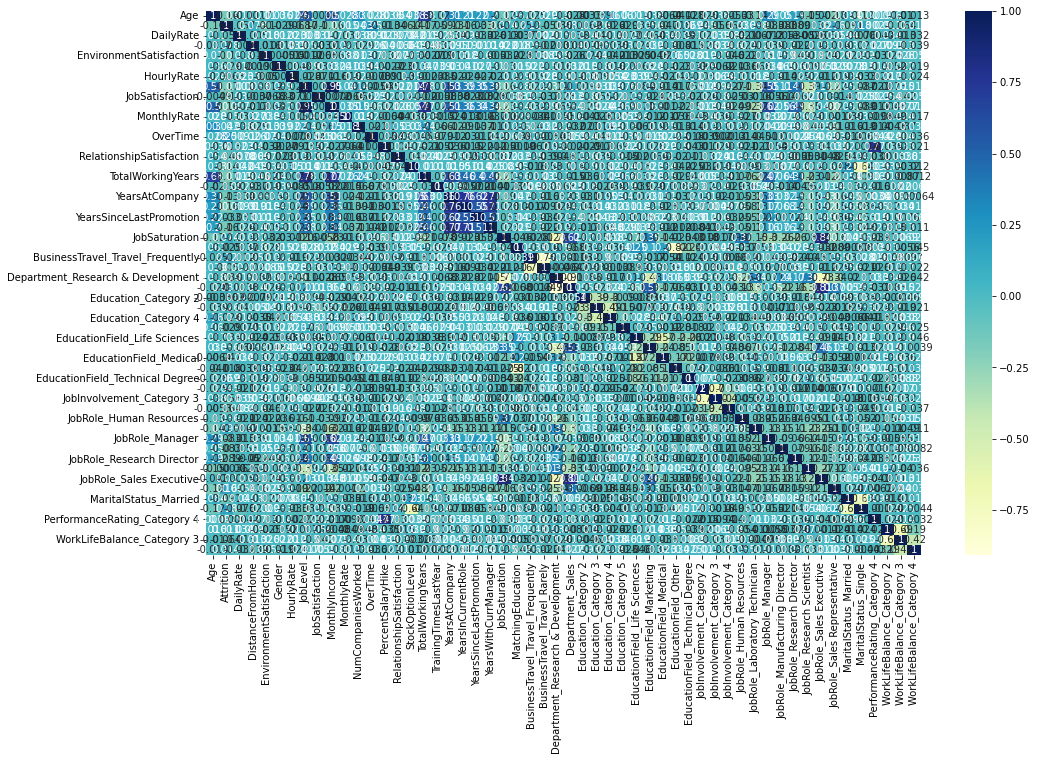

In [15]:
# At a glance, darker blue areas are features that are highly correlated (With the exception of corr =1 which is correlation with itself)
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [16]:
# Analysing datapoints that have high correlation
corr_df = df.corr()

# Convert correlation df into matrix with nan and correlated
def corr_filter(x):
    # Correlation threshold 
    if x <1 and x>=0.9:
        return 'HC' # Highly Correlated
    return np.nan

for i in corr_df.columns:
    corr_df[i] = corr_df[i].apply(lambda x: corr_filter(x))

# Print features that have high correlation
corr_df = corr_df.dropna(how = 'all', axis =1).dropna(how= 'all', axis =0)
corr_df

,JobLevel,MonthlyIncome
JobLevel,NaN,HC
MonthlyIncome,HC,NaN


In [17]:
# Since only MonthlyIncome is highly correlated, we remove the col
df = df.drop('MonthlyIncome', axis =1)
print(df.shape)

# Show counts
df.head(3)

# Export for team
# df.to_csv('DBA4811 Final Project Clean Dataset.csv')

(1470, 53)


,Age,Attrition,DailyRate,DistanceFromHome,EnvironmentSatisfaction,Gender,HourlyRate,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobSaturation,MatchingEducation,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,Education_Category 2,Education_Category 3,Education_Category 4,Education_Category 5,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobInvolvement_Category 2,JobInvolvement_Category 3,JobInvolvement_Category 4,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,PerformanceRating_Category 4,WorkLifeBalance_Category 2,WorkLifeBalance_Category 3,WorkLifeBalance_Category 4
0,41,1,1102,1,2,1,94,2,4,19479,8,1,11,1,0,8,0,6,4,0,5,0.730942,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,49,0,279,8,3,0,61,2,2,24907,1,0,23,4,1,10,3,10,7,1,7,0.303850,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
2,37,1,1373,2,4,0,92,1,3,2396,6,1,15,2,0,7,3,0,0,0,0,0.269511,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


# Classification Models
- Adaboost
- Naive Bayes Classifier
- Decision Tree Classifier
- Support Vector Machines (SVM) Classifier
- K-Nearest Neighbours (KNN) Classification
- Logistic Regression With Regularisation (Ridge & Lasso)

In [18]:
# Split df into test and training sets
X = df.drop(columns = ['Attrition'])
y = df['Attrition'] # Target variable

ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns) 

X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size = 0.30, random_state = 0)

# Model 1: Random Forest

In [19]:
# Random Search CV to tune hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['sqrt']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(
                        estimator = RandomForestClassifier(oob_score=True, random_state = 0),
                        param_distributions = random_grid,
                        n_iter = 100, cv = 3,
                        verbose=2, random_state=0, 
                        scoring='roc_auc')

rf_random.fit(X_train, y_train)

# finding best parameters
rf_best_params = rf_random.best_params_
print("Best Parameters for Random Forest:", rf_best_params)

### Best params for reference, hidden as processing outputs unnecessary
        # {'n_estimators': 246, 
        # 'min_samples_split': 10, 
        # 'min_samples_leaf': 1, 
        # 'max_leaf_nodes': 43, 
        # 'max_features': 'sqrt', 
        # 'max_depth': 90, 
        # 'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=2, n_estimators=283; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=2, n_estimators=283; total time=   0.0s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, max_leaf_nodes=48, min_samples_leaf=1, min_samples_split=2, n_estimators=283; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=33, min_samples_leaf=10, min_samples_split=2, n_estimators=161; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=33, min_samples_leaf=10, min_samples_split=2, n_estimators=161; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=33, min_samples_leaf=10, min_samples_split=2, n_estimators=161; total time=   0.3s
[

[CV] END bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=18, min_samples_leaf=10, min_samples_split=2, n_estimators=553; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=18, min_samples_leaf=10, min_samples_split=2, n_estimators=553; total time=   0.9s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=18, min_samples_leaf=10, min_samples_split=2, n_estimators=553; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=10, n_estimators=283; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=10, n_estimators=283; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=10, n_estimators=283; total time=   0.5s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt,

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=10, min_samples_split=2, n_estimators=308; total time=   0.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=10, min_samples_split=2, n_estimators=308; total time=   0.5s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=10, min_samples_split=2, n_estimators=308; total time=   0.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=10, n_estimators=393; total time=   0.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=10, n_estimators=393; total time=   0.6s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_leaf_nodes=24, min_samples_leaf=4, min_samples_split=10, n_estimators=393; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, max_

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, max_leaf_nodes=26, min_samples_leaf=10, min_samples_split=5, n_estimators=577; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, max_leaf_nodes=47, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, max_leaf_nodes=31, min_samples_leaf=4, min_samples_split=5, n_estimators=222; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, max_leaf_nodes=31, min_samples_leaf=4, min_samples_split=5, n_estimators=222; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, max_l

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_samples_split=10, n_estimators=540; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, max_leaf_nodes=40, min_samples_leaf=4, min_samples_split=10, n_estimators=540; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, max_leaf_nodes=17, min_samples_leaf=1, min_samples_split=10, n_estimators=614; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, max_leaf_nodes=17, min_samples_leaf=1, min_samples_split=10, n_estimators=614; total time=   0.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, max_leaf_nodes=17, min_samples_leaf=1, min_samples_split=10, n_estimators=614; total time=   0.9s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_leaf_nodes=30, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   1.1s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, max_

[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=38, min_samples_leaf=4, min_samples_split=5, n_estimators=381; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=38, min_samples_leaf=4, min_samples_split=5, n_estimators=381; total time=   0.6s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, max_leaf_nodes=38, min_samples_leaf=4, min_samples_split=5, n_estimators=381; total time=   0.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, max_leaf_nodes=48, min_samples_leaf=10, min_samples_split=2, n_estimators=332; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, max_leaf_nodes=48, min_samples_leaf=10, min_samples_split=2, n_estimators=332; total time=   0.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, max_leaf_nodes=48, min_samples_leaf=10, min_samples_split=2, n_estimators=332; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, max_leaf

/Users/yolanz/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
159 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
159 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yolanz/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yolanz/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 437, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fi

Best Parameters for Random Forest: {'n_estimators': 246, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 43, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


CV ROC AUC score is: 0.767


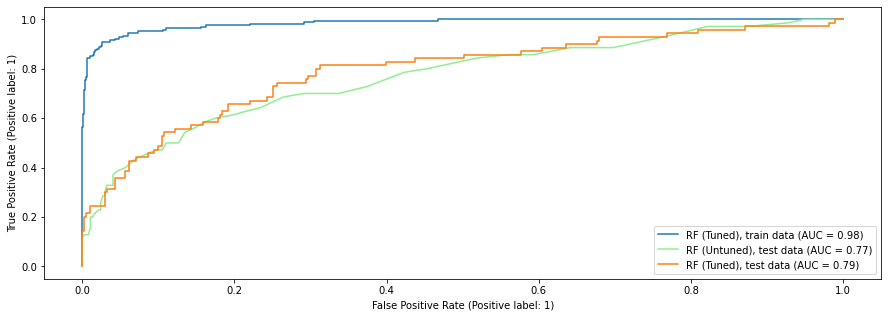

In [20]:
# Apply best parameters
rf_not_tuned = RandomForestClassifier(n_estimators= 100, random_state= 0)
rf_tuned = RandomForestClassifier(n_estimators= rf_best_params['n_estimators'],
                                    min_samples_split =  rf_best_params['min_samples_split'],
                                    min_samples_leaf =  rf_best_params['min_samples_leaf'],
                                    max_leaf_nodes =  rf_best_params['max_leaf_nodes'],
                                    max_features = rf_best_params['max_features'],
                                    max_depth =  rf_best_params['max_depth'],
                                    bootstrap =  rf_best_params['bootstrap'], random_state= 0)

rf_not_tuned.fit(X_train, y_train)
rf_tuned.fit(X_train, y_train)

# ROCAUC Curve
hfig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)

# ROC of train data
RocCurveDisplay.from_estimator(rf_tuned, X_train, y_train, ax=ax, name="RF (Tuned), train data")

# ROC on test data
RocCurveDisplay.from_estimator(rf_not_tuned, X_test, y_test,ax=ax, name="RF (Untuned), test data", color = 'lightgreen')
RocCurveDisplay.from_estimator(rf_tuned, X_test, y_test,ax=ax, name="RF (Tuned), test data")

# Cross validated auc
cv_auc_rf = cross_val_score(rf_tuned, X_test, y_test, scoring='roc_auc', cv=10).mean().round(3)
print('CV ROC AUC score is:', cv_auc_rf)

# Plot
plt.show()

In [21]:
# Defining the modelling function
def modeling(alg, alg_name, params={}):
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_true, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_true, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_true, y_pred)                            
        print("recall: ",rec_score)
        f_score = f1_score(y_true, y_pred, average='weighted')
        print("f1_score: ",f_score)

    print_scores(alg, y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    #Create the Confusion Matrix Display Object(cmd_obj). 
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['Attrited', 'Not Attrited'])

    #The plot() function has to be called for the sklearn visualization
    cmd_obj.plot()

    #Use the Axes attribute 'ax_' to get to the underlying Axes object.
    #The Axes object controls the labels for the X and the Y axes. It also controls the title.
    cmd_obj.ax_.set(
                    title='Confusion Matrix', 
                    xlabel='Predicted Attrition', 
                    ylabel='Actual Attrition')
    #Finally, call the matplotlib show() function to display the visualization of the Confusion Matrix.
    plt.show()
    
    return model

RandomForestClassifier(max_depth=90, max_leaf_nodes=43, min_samples_split=10,
                       n_estimators=246, random_state=0)
accuracy:  0.854875283446712
precision:  0.7142857142857143
recall:  0.14285714285714285
f1_score:  0.8115924732466085


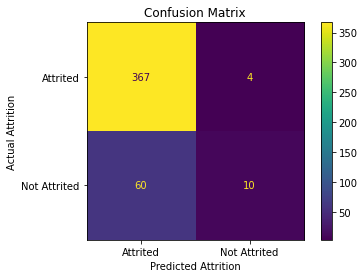

RandomForestClassifier()

In [22]:
rf_cm = modeling(RandomForestClassifier, rf_tuned)
rf_cm

# Model 2: Adaboosting

**Hyperparameter tuning to find optimal metrics** 

In [23]:
# Grid Search CV to tune hyperparameters
hyperparam_grid = {'n_estimators':list(range(10, 100, 10)), 
                    'learning_rate':[0.001, 0.01, 1]}

ada = AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth = 1, random_state = 0), 
                        random_state=0)

gs = GridSearchCV(estimator=ada,
                  param_grid=hyperparam_grid, 
                  scoring="roc_auc", 
                  n_jobs=1, 
                  cv=5,
                  return_train_score=True)

ada_result = gs.fit(X_train, y_train)

# finding best parameters
ab_best_params = ada_result.best_params_
print("Best Parameters for Adaboost:", ab_best_params)

Best Parameters for Adaboost: {'learning_rate': 1, 'n_estimators': 50}


CV ROC AUC score is: 0.771


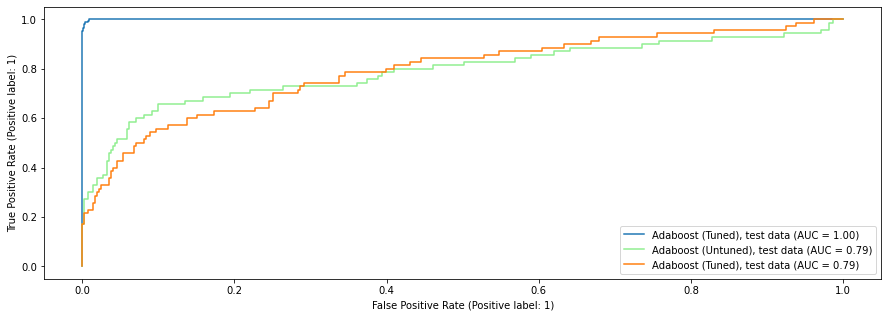

In [24]:
# Apply best parameters
best_ada = AdaBoostClassifier(base_estimator = rf_tuned, # Using tuned random forest as base model 
                                n_estimators = ab_best_params['n_estimators'], 
                                learning_rate = ab_best_params['learning_rate'], 
                                random_state = 0)

ada_not_tuned = ada.fit(X_train, y_train)
ada_results = best_ada.fit(X_train, y_train)

# ROCAUC Curve
hfig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)

# ROC on train data
RocCurveDisplay.from_estimator(ada_results, X_train, y_train, ax=ax, name="Adaboost (Tuned), test data")

# ROC on test data
RocCurveDisplay.from_estimator(ada_not_tuned, X_test, y_test,ax=ax, name="Adaboost (Untuned), test data", color = 'lightgreen')
RocCurveDisplay.from_estimator(ada_results, X_test, y_test,ax=ax, name="Adaboost (Tuned), test data")

# Cross validated auc
cv_auc_ada = cross_val_score(best_ada, X_test, y_test, scoring='roc_auc', cv=10).mean().round(3)
print('CV ROC AUC score is:', cv_auc_ada )

# Plot
plt.show()

AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=90,
                                                         max_leaf_nodes=43,
                                                         min_samples_split=10,
                                                         n_estimators=246,
                                                         random_state=0),
                   learning_rate=1, random_state=0)
accuracy:  0.873015873015873
precision:  0.6842105263157895
recall:  0.37142857142857144
f1_score:  0.8568284046320223


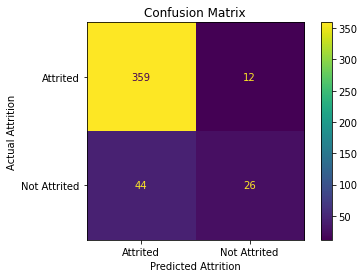

AdaBoostClassifier()

In [25]:
ada_cm = modeling(AdaBoostClassifier, ada_results)
ada_cm

# Model 3: Naive Bayes Classifier

In [26]:
# Find best parameters using gridsearch CV
gnb = nb.GaussianNB()

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
                
nbModel_grid = GridSearchCV(estimator= nb.GaussianNB(), 
                            param_grid=param_grid_nb, 
                            verbose=1, 
                            cv=10, 
                            n_jobs=-1)

nb_result = nbModel_grid.fit(X_train, y_train)

# finding best parameters
nb_best_params = nbModel_grid.best_params_
print("Best Parameters for Naive Bayes:", nb_best_params)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters for Naive Bayes: {'var_smoothing': 1.0}


CV ROC AUC score is: 0.72


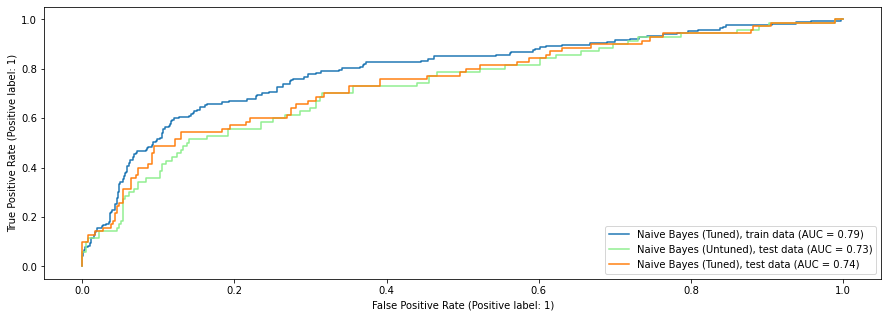

In [27]:
# Apply best parameters
best_nb = nb.GaussianNB(var_smoothing= nb_best_params['var_smoothing'])

nb_not_tuned = gnb.fit(X_train, y_train)
nb_results = best_nb.fit(X_train, y_train)

# ROCAUC Curve
hfig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)

# ROC on training data
RocCurveDisplay.from_estimator(best_nb, X_train, y_train,ax=ax, name="Naive Bayes (Tuned), train data")

# ROC on test data
RocCurveDisplay.from_estimator(nb_not_tuned, X_test, y_test,ax=ax, name="Naive Bayes (Untuned), test data", color = 'lightgreen')
RocCurveDisplay.from_estimator(best_nb, X_test, y_test,ax=ax, name="Naive Bayes (Tuned), test data")

# CV
cv_auc_nb = cross_val_score(best_nb, X_test, y_test, scoring='roc_auc', cv=10).mean().round(3)
print('CV ROC AUC score is:', cv_auc_nb )

# Plot
plt.show()

GaussianNB(var_smoothing=1.0)
accuracy:  0.6575963718820862
precision:  0.2737430167597765
recall:  0.7
f1_score:  0.7030598886934182


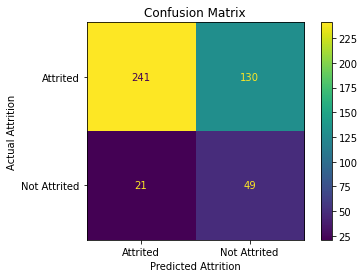

GaussianNB()

In [28]:
nb_cm = modeling(nb.GaussianNB, best_nb)
nb_cm

# Model 4: Support Vector Machine Classifier (SVM)

In [29]:
# Gridsearch cv to tune hyperparameters 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid_svm = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
svm_result = grid_svm.fit(X_train, y_train)

# finding best parameters
svm_best_params = grid_svm.best_params_
print("Best Parameters for SVM:", svm_best_params)

# Best param results, hidden as uneccesary
# {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.840 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.840 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.839 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.840 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.840 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.839 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.840 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.839 total time=   0.1s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.840 total time=   0.1s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.840 total time=   0.1s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.835 total time=   0.1s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.839 total time=   0.1s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.835 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.879 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.845 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.854 total time=   0.0s
[CV 5/5] END ....C=1000, gam

CV ROC AUC score is: 0.809


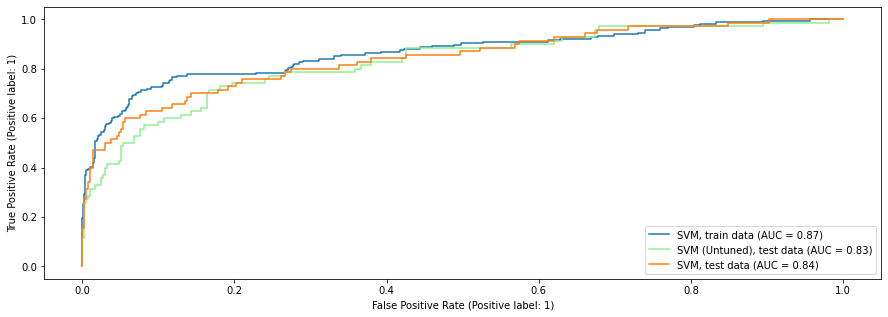

In [30]:
# apply best parameters
svc_not_tuned = SVC(random_state= 0)

svm_tuned = SVC(C = svm_best_params['C'], 
                gamma = svm_best_params['gamma'], 
                kernel = svm_best_params['kernel'], 
                random_state= 0, probability = True)

svc_ut = svc_not_tuned.fit(X_train, y_train)                
svc = svm_tuned.fit(X_train, y_train)

# ROCAUC curve
hfig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)

# ROC on training data
RocCurveDisplay.from_estimator(svc, X_train, y_train, ax=ax, name="SVM, train data")

# ROC on test data
RocCurveDisplay.from_estimator(svc_not_tuned, X_test, y_test,ax=ax, name="SVM (Untuned), test data", color = 'lightgreen')
RocCurveDisplay.from_estimator(svc, X_test, y_test,ax=ax, name="SVM, test data")

# CV
cv_auc_svc = cross_val_score(svc, X_test, y_test, scoring='roc_auc', cv=10).mean().round(3)
print('CV ROC AUC score is:', cv_auc_svc )

# Plot
plt.show()

SVC(C=1000, gamma=0.0001, probability=True, random_state=0)
accuracy:  0.873015873015873
precision:  0.9375
recall:  0.21428571428571427
f1_score:  0.8374560139197279


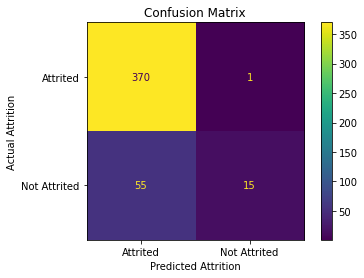

SVC()

In [31]:
svm_cm = modeling(SVC, svm_tuned)
svm_cm

# Model 5: K-nearest Neighbours

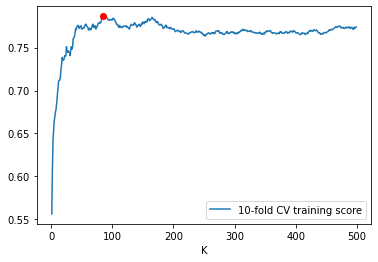

Best K = 84


In [32]:
# Cross validation to find ideal k
# range of K to try (need to do a bit of trial and error)
K_vec = range(1,500,1) 
Nfolds = 10

# results list 
cvResults = []

# iterate over all K in range
for cur_K in K_vec:
    # Step 1. Create the estimator object
    knn_cv = knn.KNeighborsClassifier(n_neighbors=cur_K, weights="uniform", p=2, n_jobs= 4)   
    # Perform 10-fold cross validation 
    scores = cross_val_score(estimator = knn_cv, X = X_train, y = y_train, cv = Nfolds, \
                             scoring = 'roc_auc', n_jobs = 4)
    # Attach results
    cvResults.append(scores.mean())

# find the best K
idx_best_K = np.array(cvResults).argmax() # index of best K
    
# plot results
plt.figure()
sns.lineplot(y = cvResults, x = K_vec, label = f"{Nfolds}-fold CV training score")
plt.xlabel('K')
plt.plot(K_vec[idx_best_K], cvResults[idx_best_K], "ro")
plt.show()

# report best K
print(f"Best K = {K_vec[idx_best_K]}")

CV ROC AUC score is: 0.721


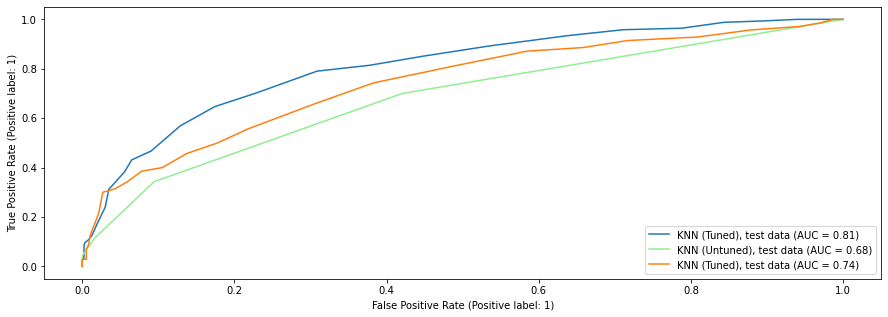

In [33]:
# Refit to best model and evaluate
# Step 1. define the model object with new parameters
knn_not_tuned = knn.KNeighborsClassifier() 
best_knn = knn.KNeighborsClassifier(n_neighbors=K_vec[idx_best_K], weights="uniform", p=2, n_jobs= 4) 

# Step 2. Call the "fit" function to do the fitting 
knn_not_tuned.fit(X_train, y_train)
best_knn.fit(X_train, y_train)

# ROCAUC curve
hfig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)

# ROC on train data
RocCurveDisplay.from_estimator(best_knn, X_train, y_train,ax=ax, name="KNN (Tuned), test data")

# ROC on test data
RocCurveDisplay.from_estimator(knn_not_tuned, X_test, y_test,ax=ax, name="KNN (Untuned), test data", color = 'lightgreen')
RocCurveDisplay.from_estimator(best_knn, X_test, y_test,ax=ax, name="KNN (Tuned), test data")

# CV
cv_auc_knn = cross_val_score(best_knn, X_test, y_test, scoring='roc_auc', cv=10).mean().round(3)
print('CV ROC AUC score is:', cv_auc_knn )

# Plot
plt.show()

KNeighborsClassifier(n_jobs=4, n_neighbors=84)
accuracy:  0.8458049886621315
precision:  0.5714285714285714
recall:  0.11428571428571428
f1_score:  0.7998170028245216


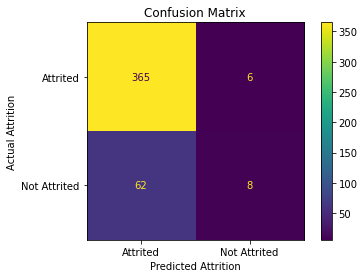

KNeighborsClassifier()

In [34]:
knn_cm = modeling(knn.KNeighborsClassifier, best_knn)
knn_cm

# Combined ROC Curves

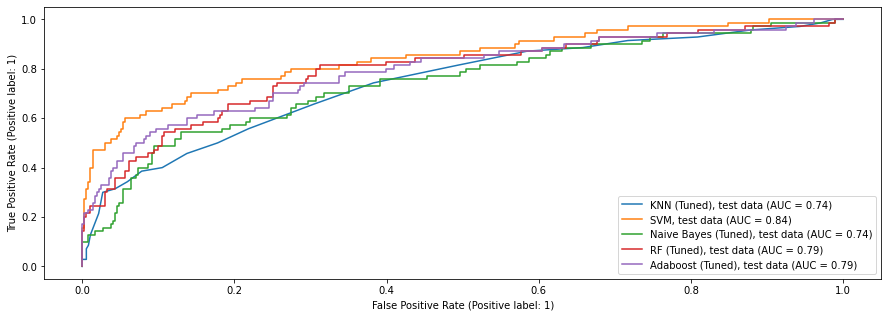

In [35]:
### Visualising all ROC Curves in one chart
# ROCAUC curve
hfig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)

RocCurveDisplay.from_estimator(best_knn, X_test, y_test,ax=ax, name="KNN (Tuned), test data")
RocCurveDisplay.from_estimator(svc, X_test, y_test,ax=ax, name="SVM, test data")
RocCurveDisplay.from_estimator(best_nb, X_test, y_test,ax=ax, name="Naive Bayes (Tuned), test data")
RocCurveDisplay.from_estimator(rf_tuned, X_test, y_test,ax=ax, name="RF (Tuned), test data")
RocCurveDisplay.from_estimator(ada_results, X_test, y_test,ax=ax, name="Adaboost (Tuned), test data")

# Combined CV AUC Scores (With Logistic Reg)

Text(0.5, 1.0, 'CV AUC Score for Models')

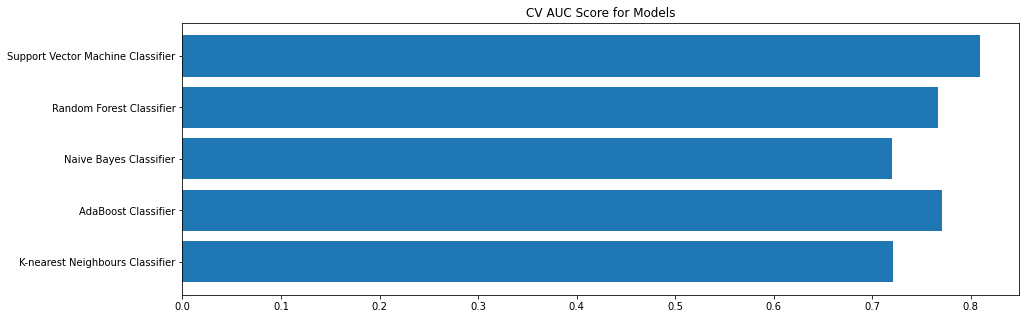

In [36]:
cv_auc_scores = [cv_auc_knn, cv_auc_ada, cv_auc_nb, cv_auc_rf, cv_auc_svc]
titles = ['K-nearest Neighbours Classifier', 'AdaBoost Classifier', 'Naive Bayes Classifier', 'Random Forest Classifier', 'Support Vector Machine Classifier']

# Plot Cross validated scores
hfig = plt.figure(figsize = (15, 5))
ax = plt.subplot(111)

plt.barh(titles, cv_auc_scores)
plt.title('CV AUC Score for Models')